<a href="https://colab.research.google.com/github/hugo-degrossi/cesi_data_science/blob/main/livrable_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Remove noise from images using deep learning with Tensorflow & Keras

**Objective**: We want to remove noise from image data

**Dataset**: We're using CESI delivrable 1 pictures dataset.

## Mounting G. Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2
import random

from imgaug import augmenters

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, roc_curve, auc

## Utils

fonction that can be used everywhere. We'll use them to load images, plot them, plot graphs, ...
Putting those here will reduce the code overload on the other cells.


In [3]:
# useful functions

def load_all_images(datasets, img_height, img_width, max_images, base_path):
    X = []
    y = []
    for dataset in datasets:
        images_list = os.listdir(base_path + dataset['path'])
        loaded_images = []
        for idx, image in enumerate(images_list):
            img = tf.keras.preprocessing.image.load_img(
                    base_path + dataset['path'] + '/' + image,
                    target_size=(img_height, img_width))
            X.append(np.asarray(img))
            y.append(dataset['name'])
            
            if (idx == max_images): break
    return np.array(X), np.array(y)

def plot_five(X):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(20, 20)
    for i in range(5):
        ax[i].axis('off')
        ax[i].imshow(X[i])
    plt.show()

def plot_curve(name, x_label, y_label, x, y):
  plt.plot(x)
  plt.plot(y)
  plt.title(name)
  plt.ylabel(x_label)
  plt.xlabel(y_label)
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def plt_conf(y_test, y_pred, classes):
  n_classes = len(classes)

  fig, ax = plt.subplots(1,n_classes, figsize=(15, 15))
  for i in range(n_classes):
    conf_matrix = confusion_matrix(y_test[:, i], np.rint(y_pred[:, i]))
    ax[i].matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    ax[i].set_title(classes[i])
    for j in range(conf_matrix.shape[0]):
        for k in range(conf_matrix.shape[1]):
            ax[i].text(x=k, y=j,s=conf_matrix[j, k], va='center', ha='center')
            ax[i].set_ylabel('predicted')
            ax[i].set_xlabel('real')

  score = cnn.evaluate(X_test, y_test, verbose = 0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

def roc_curve_plot(fpr, tpr, roc_auc, classes):
  plt.figure()
  lw = 2

  for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'RF (area = {roc_auc[i]:.3f}) class = {classes[i]}')
  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic example")
  plt.legend(loc="lower right")
  plt.show()

def add_noise(data, pepper):
  noise = augmenters.SaltAndPepper(pepper)
  seq_object = augmenters.Sequential([noise])
  return seq_object.augment_images(data)

## Load data
Load the datasets.

In [4]:
base_path = "/content/drive/MyDrive/livrable_1/"

# all datasets and their labels
datasets = [
    {'name':'photo', 'path':"Photo/Photo"},
]

# define an image size
img_height = 128
img_width = 128

n_images_per_class = 10000

In [5]:
data, labels = load_all_images(datasets, img_height, img_width, n_images_per_class, base_path)

## Have a look at data

We want to have a first look at the data to be sure it's exact.

Number of images X: 10001
Image shape: (128, 128, 3)
Classes: 
photo    10001
dtype: int64




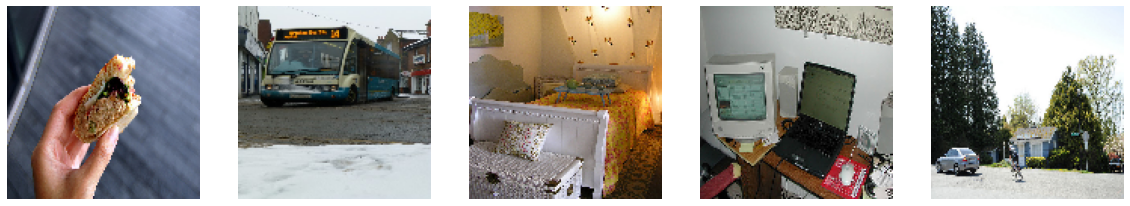

In [6]:
print(f"Number of images X: {len(data)}")
print(f"Image shape: {data[0].shape}")
print(f"Classes: \n{pd.DataFrame(labels).value_counts()}\n\n")
plot_five(data)

as we can see, the data have been formated and is in gray shades as planned.

## Add noise

We will add a noise matrix to the images with a bit of random so that it's not always the same.

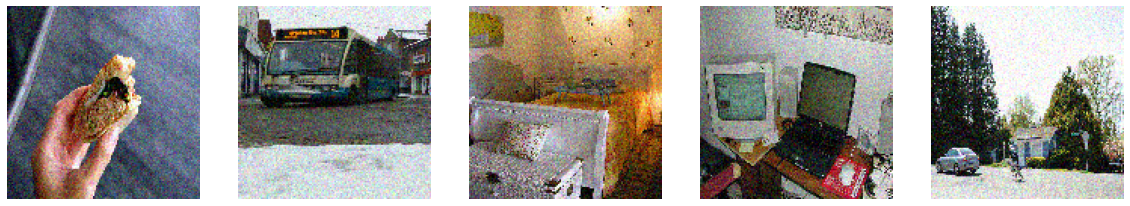

In [7]:
#data_noised = add_noise(data, .05)
data_norm = data / 255

noise_factor = random.uniform(0.05, 0.2)
data_noised = data_norm + noise_factor * tf.random.normal(shape=data.shape)
data_noised = tf.clip_by_value(data_noised, clip_value_min=0., clip_value_max=1.).numpy()

plot_five(data_noised)


## Normalize
We want to normalize the data so it's trainable for our deep learning neural network (else it would use too much machine power for less results).

In [8]:
# normalize 
X = data_noised
y = data_norm

## Split data

Splitting the data into train, validation and test dataset. The validation dataset will help us checking and reducing overfitting.
- Train: 72%
- Validation: 8%
- Test: 20%

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

print(f"Number of images X_train: {len(X_train)}, and y_train: {len(y_train)}")
print(f"Number of images X_val: {len(X_val)}, and y_train: {len(y_val)}")
print(f"Number of images X_test: {len(X_test)}, and y_train: {len(y_test)}")

Number of images X_train: 7200, and y_train: 7200
Number of images X_val: 800, and y_train: 800
Number of images X_test: 2001, and y_train: 2001


## Basic params

Defining basic params to be used afterwards.

In [10]:
batch_size       = 64
epochs           = 200
fit_verbosity    = 1

## Modelling

- We will go for a simple auto-encoder with 4 convolution layer, it will allow our neural network to have an  image comprehension by searching patterns and schemes.
- We will use multiple dropout layers to prevent overfitting

In [11]:
# encoder

# input
inputs = layers.Input(shape=(img_height,img_width, 3))

# convolution with dropout

# 1ST LAYER
x = layers.Conv2D(8, (4,4), padding='same', activation="relu")(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(.2)(x)

# 2ND LAYER
x = layers.Conv2D(32, (3,3), padding='same', activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(.2)(x)

# 3RD LAYER
x = layers.Conv2D(32, (3,3), padding='same', activation="relu")(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Dropout(.2)(x)

# 4TH LAYER
x = layers.Conv2D(16, (4,4), padding='same', activation="relu")(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Dropout(.2)(x)

# output
outputs = layers.Conv2D(3, (3,3), padding='same', activation="relu")(x)

auto_encoder = Model(inputs, outputs, name='auto_encoder')
auto_encoder.summary()

Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 8)       392       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        2336      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

In [12]:
auto_encoder.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy']
)

The model is now compiled and ready to be trained, we'll evaluate it using the MSE and accuracy.

## Training

We will now train our model, but first we'll convert all the train, val and test sets to numpy array (compatibility and performance issue etherwise).

In [13]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [14]:
history = auto_encoder.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=fit_verbosity,
)

Epoch 1/200
113/113 [==============================] - 17s 66ms/step - loss: 0.0582 - accuracy: 0.4116 - val_loss: 0.0488 - val_accuracy: 0.6357
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 0.0218 - accuracy: 0.5832 - val_loss: 0.0352 - val_accuracy: 0.6749
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 0.0180 - accuracy: 0.6327 - val_loss: 0.0310 - val_accuracy: 0.7052
Epoch 4/200
113/113 [==============================] - 7s 60ms/step - loss: 0.0166 - accuracy: 0.6616 - val_loss: 0.0279 - val_accuracy: 0.7053
Epoch 5/200
113/113 [==============================] - 7s 60ms/step - loss: 0.0158 - accuracy: 0.6706 - val_loss: 0.0254 - val_accuracy: 0.7060
Epoch 6/200
113/113 [==============================] - 7s 60ms/step - loss: 0.0152 - accuracy: 0.6745 - val_loss: 0.0238 - val_accuracy: 0.7011
Epoch 7/200
113/113 [==============================] - 7s 60ms/step - loss: 0.0148 - accuracy: 0.6801 - val_loss: 0.0222 - val_accuracy

Model trained, we'll now have a look at the learning curves.

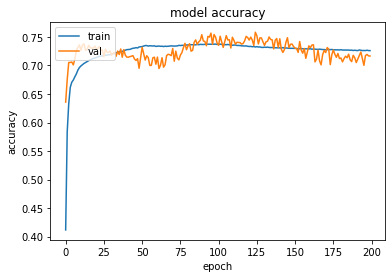

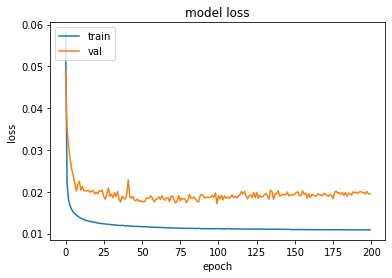

In [15]:
plot_curve('model accuracy', 'accuracy', 'epoch', history.history['accuracy'], history.history['val_accuracy'])
plot_curve('model loss', 'loss', 'epoch', history.history['loss'], history.history['val_loss'])

As we can see we have a bit of overfitting after 100 epochs, we could limit the training to this number of epoch for another evaluation. Before judging if it's necessary we'll have a look at the model output.

## Testing


225/225 [==============================] - 2s 8ms/step


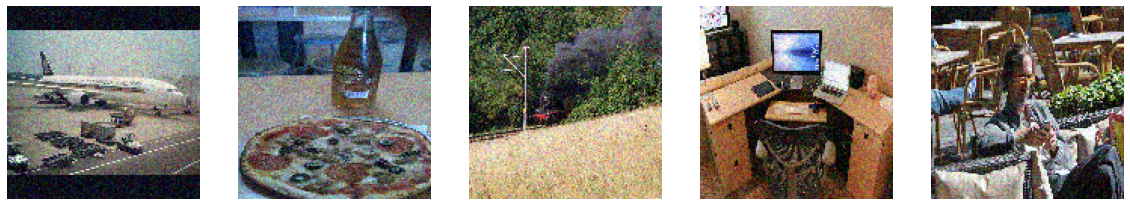

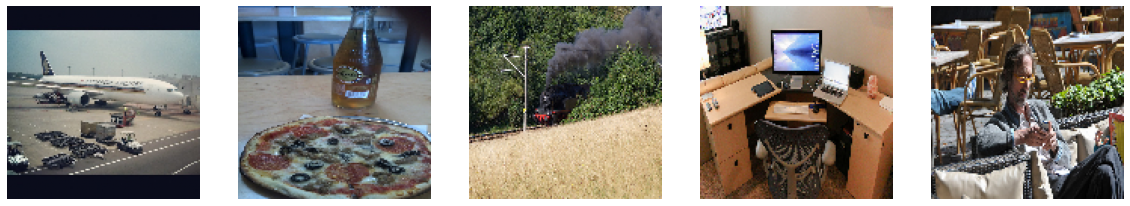

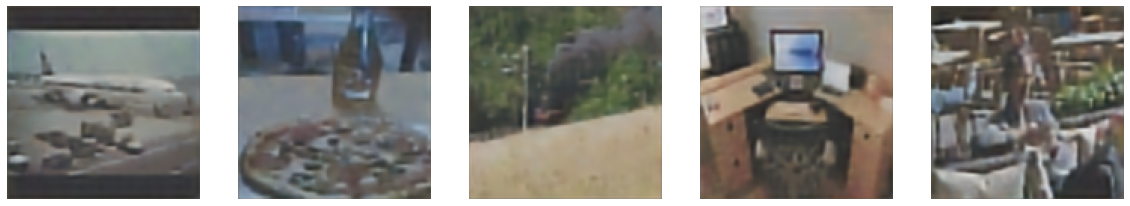

In [16]:
# predict train data
y_pred = auto_encoder.predict(X_train)
# initial data
plot_five(X_train)
# what should have been predicted
plot_five(y_train)
# what was predicted
plot_five(y_pred)

63/63 [==============================] - 1s 10ms/step


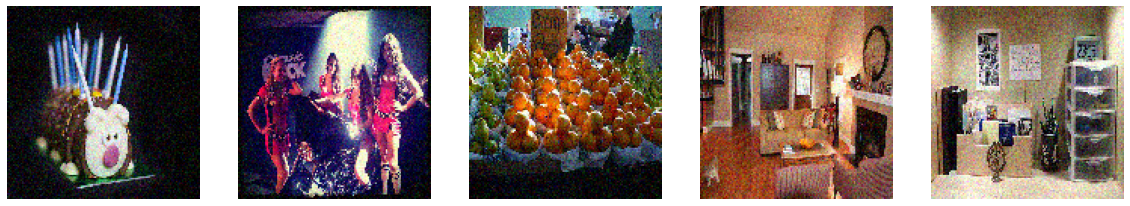

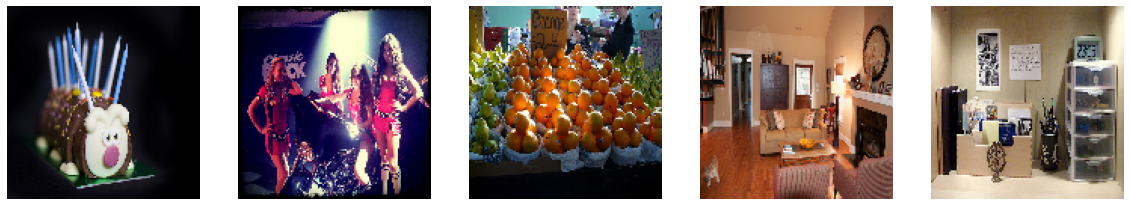

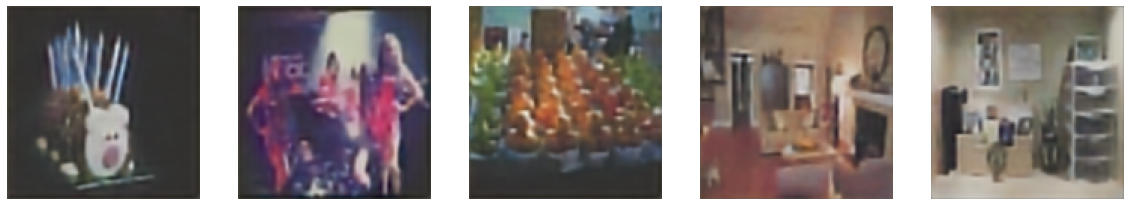

In [17]:
# predict test data
y_pred = auto_encoder.predict(X_test)
# initial data
plot_five(X_test)
# what should have been predicted
plot_five(y_test)
# what was predicted
plot_five(y_pred)

As we can see we don't have a lot of overfitting visible on the images themselves, in fact the model is able to remove the noise on both train and test set and keep relevant image, however we have some blur on the image which was not here at the start.